# RL Homework

In [1]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
%matplotlib inline
%config InlineRenderer.figure_format = 'retina'

For our RL homework we'll work with another classic control environment: Acrobot. Acrobot consists of a double pendulum where the agent can apply a torque at the joint in the middle.

```
     o <-- fixed hinge
    /
   / <-- First rod (can swing aroung the fixed hinge
  /
 o <-- Actuated joint (the agent applies torque here)
  \
   \ <-- Second rod (can swing around the actuated joint)
    \
     o <-- free swinging end
```

The state space for this environment consists of 6 real numbers: the cosine and sine of each of the angle at each joint and the angular velocity at each joint. There are three actions: apply clockwise torque at the actuated joint, apply a counterclockwise torque, or do nothing. The goal of this environment is to swing the free end up to a target height. It gets a reward of -1 at each time step until it reaches the target height, at which point the reward is 0. An episode is truncated after 500 steps. A good total (non-discounted) reward on this environment is around -100.

This code for the Acrobot environment is taken from [Gymnasium](https://gymnasium.farama.org/environments/classic_control/acrobot/#starting-state), a library of reinforcement learning environments that are commonly used as a test bed by researchers.

In [2]:
class AcrobotEnv:

    dt = 0.2

    LINK_LENGTH_1 = 1.0  # [m]
    LINK_LENGTH_2 = 1.0  # [m]
    LINK_MASS_1 = 1.0  #: [kg] mass of link 1
    LINK_MASS_2 = 1.0  #: [kg] mass of link 2
    LINK_COM_POS_1 = 0.5  #: [m] position of the center of mass of link 1
    LINK_COM_POS_2 = 0.5  #: [m] position of the center of mass of link 2
    LINK_MOI = 1.0  #: moments of inertia for both links

    MAX_VEL_1 = 4 * np.pi
    MAX_VEL_2 = 9 * np.pi

    AVAIL_TORQUE = [-1.0, 0.0, +1]

    torque_noise_max = 0.0

    SCREEN_DIM = 500

    #: use dynamics equations from the nips paper or the book
    book_or_nips = "book"
    action_arrow = None
    domain_fig = None
    actions_num = 3

    def __init__(self, dense_reward=False):
        self.screen = None
        self.clock = None
        self.isopen = True
        high = np.array(
            [1.0, 1.0, 1.0, 1.0, self.MAX_VEL_1, self.MAX_VEL_2], dtype=np.float32
        )
        low = -high
        self.state_dim = 6
        self.num_actions = 3
        self.state = None
        self.np_random = np.random.default_rng()
        self.dense_reward = dense_reward

    def reset(self):
        self.state = self.np_random.uniform(low=-0.1, high=0.1, size=(4,)).astype(
            np.float32
        )
        
        self.count = 0
        return self._get_ob(), {}

    def step(self, a):
        s = self.state
        assert s is not None, "Call reset before using AcrobotEnv object."
        torque = self.AVAIL_TORQUE[a]

        # Add noise to the force action
        if self.torque_noise_max > 0:
            torque += self.np_random.uniform(
                -self.torque_noise_max, self.torque_noise_max
            )

        # Now, augment the state with our force action so it can be passed to
        # _dsdt
        s_augmented = np.append(s, torque)

        ns = rk4(self._dsdt, s_augmented, [0, self.dt])

        ns[0] = wrap(ns[0], -np.pi, np.pi)
        ns[1] = wrap(ns[1], -np.pi, np.pi)
        ns[2] = bound(ns[2], -self.MAX_VEL_1, self.MAX_VEL_1)
        ns[3] = bound(ns[3], -self.MAX_VEL_2, self.MAX_VEL_2)
        self.state = ns
        terminated = self._terminal()
        reward = -1.0 if not terminated else 0.0
        if self.dense_reward:
            reward = - np.cos(ns[0]) - np.cos(ns[0] + ns[1]) - 1.0
        self.count += 1

        return self._get_ob(), reward, terminated, self.count >= 500, {}

    def _get_ob(self):
        s = self.state
        assert s is not None, "Call reset before using AcrobotEnv object."
        return np.array(
            [np.cos(s[0]), np.sin(s[0]), np.cos(s[1]), np.sin(s[1]), s[2], s[3]], dtype=np.float32
        )

    def _terminal(self):
        s = self.state
        assert s is not None, "Call reset before using AcrobotEnv object."
        return bool(-np.cos(s[0]) - np.cos(s[1] + s[0]) > 1.0)

    def _dsdt(self, s_augmented):
        m1 = self.LINK_MASS_1
        m2 = self.LINK_MASS_2
        l1 = self.LINK_LENGTH_1
        lc1 = self.LINK_COM_POS_1
        lc2 = self.LINK_COM_POS_2
        I1 = self.LINK_MOI
        I2 = self.LINK_MOI
        g = 9.8
        a = s_augmented[-1]
        s = s_augmented[:-1]
        theta1 = s[0]
        theta2 = s[1]
        dtheta1 = s[2]
        dtheta2 = s[3]
        d1 = (
            m1 * lc1**2
            + m2 * (l1**2 + lc2**2 + 2 * l1 * lc2 * np.cos(theta2))
            + I1
            + I2
        )
        d2 = m2 * (lc2**2 + l1 * lc2 * np.cos(theta2)) + I2
        phi2 = m2 * lc2 * g * np.cos(theta1 + theta2 - np.pi / 2.0)
        phi1 = (
            -m2 * l1 * lc2 * dtheta2**2 * np.sin(theta2)
            - 2 * m2 * l1 * lc2 * dtheta2 * dtheta1 * np.sin(theta2)
            + (m1 * lc1 + m2 * l1) * g * np.cos(theta1 - np.pi / 2)
            + phi2
        )
        if self.book_or_nips == "nips":
            # the following line is consistent with the description in the
            # paper
            ddtheta2 = (a + d2 / d1 * phi1 - phi2) / (m2 * lc2**2 + I2 - d2**2 / d1)
        else:
            # the following line is consistent with the java implementation and the
            # book
            ddtheta2 = (
                a + d2 / d1 * phi1 - m2 * l1 * lc2 * dtheta1**2 * np.sin(theta2) - phi2
            ) / (m2 * lc2**2 + I2 - d2**2 / d1)
        ddtheta1 = -(d2 * ddtheta2 + phi1) / d1
        return dtheta1, dtheta2, ddtheta1, ddtheta2, 0.0


def rk4(derivs, y0, t):

    try:
        Ny = len(y0)
    except TypeError:
        yout = np.zeros((len(t),), np.float_)
    else:
        yout = np.zeros((len(t), Ny), np.float_)

    yout[0] = y0

    for i in np.arange(len(t) - 1):
        this = t[i]
        dt = t[i + 1] - this
        dt2 = dt / 2.0
        y0 = yout[i]

        k1 = np.asarray(derivs(y0))
        k2 = np.asarray(derivs(y0 + dt2 * k1))
        k3 = np.asarray(derivs(y0 + dt2 * k2))
        k4 = np.asarray(derivs(y0 + dt * k3))
        yout[i + 1] = y0 + dt / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)
    # We only care about the final timestep and we cleave off action value which will be zero
    return yout[-1][:4]

def wrap(x, m, M):
    diff = M - m
    while x > M:
        x = x - diff
    while x < m:
        x = x + diff
    return x

def bound(x, m, M=None):
    if M is None:
        M = m[1]
        m = m[0]
    # bound x between min (m) and Max (M)
    return min(max(x, m), M)

As in previous homework assignments, I've broken this down into three sections.

NOTE: Reinforcement learning often has pretty high variance, especially for the relatively simple algorithms we've looked at in this class. If your results look like there is some learning happening but it's pretty noisy or if you see rewards going up and then back down again, it may be worth just rerunning training to see what happens. Most likely if you don't get reasonable-looking results in 2-3 runs then something is wrong.

## Q Learning (C)

The basic version of this homework involves using deep Q learning to control the Acrobot. This is very similar to what we did in class on Monday. For this part of the homework you'll need to set up the `QNetwork` to approximate the Q function and finish the training code below. The `ReplayMemory` class is already complete. Remember that Q learning involves learnign an approximation $\hat{Q}$ to the optimal Q function according to the temporal difference loss

$$
L(\hat{Q}) = \sum_{(s, a, r, s') \in D} \left \| \hat{Q}(s, a) - \left ( r + \gamma \max_{a'} \hat{Q}(s', a') \right ) \right \|
$$

The way we do exploration in this version is a bit different from what we had in class. There we took three parameters, `eps_start`, `eps_end` and `eps_rate` and we took a random action with a probability that started at `eps_start` and then exponentially decayed toward `eps_end` at a rate controlled by `eps_rate`. For this homework, we'll use a simpler approach called $\varepsilon$-greedy exploration where we always take a random action with probability $\varepsilon$ and choose an action from our Q network with probability $(1-\varepsilon)$.

In [3]:
class QNetwork(nn.Module):

    def __init__(self, state_dim, num_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, num_actions)
        )
        

    def forward(self, x):
        # Run your model on x. This should return a Q value for each action.
        return self.model(x)
    


class ReplayMemory:

    def __init__(self, cap, evict_oldest=False):
        self.capacity = cap
        self.data = []
        self.evict_oldest = evict_oldest
        if self.evict_oldest:
            self.oldest = 0

    def push(self, state, action, reward, nstate, term):
        if len(self.data) < self.capacity:
            self.data.append((state, action, reward, nstate, term))
        else:
            if self.evict_oldest:
                idx = self.oldest
                self.oldest = (self.oldest + 1) % self.capacity
            else:
                idx = random.randint(0, self.capacity - 1)
            self.data[idx] = (state, action, reward, nstate, term)

    def sample(self, batch_size):
        return random.sample(self.data, batch_size)

    def __len__(self):
        return len(self.data)

    def empty(self):
        self.data = []
        if self.evict_oldest:
            self.oldest = 0

In [18]:
def train_q_learning(env, gamma=0.99, lr=1e-3, tau=0.05, batch_size=128, num_interactions=10000, eps=0.1, sarsa=False):

    policy_network = QNetwork(env.state_dim, env.num_actions)
    target_network = QNetwork(env.state_dim, env.num_actions)
    target_network.load_state_dict(policy_network.state_dict())

    replay_buffer = ReplayMemory(10000)

    opt = optim.Adam(policy_network.parameters(), lr=lr)
    loss = nn.SmoothL1Loss()

    state, _ = env.reset()
    ep_r = 0
    ep_rewards = []

    rng = np.random.default_rng()
    for i in tqdm(range(num_interactions)):
        
        # Choose a random action with probability eps, otherwise take the best
        # action according to the policy network.

        if rng.random() < eps:
            action = rng.integers(0, env.num_actions)

        else:
            action = policy_network(torch.tensor(state, dtype=torch.float)).argmax()
        
        
        # Take a step in the environment, add the transition to the replay
        # buffer, and add the reward to ep_r
    
        nstate, reward, term, trunc, _ = env.step(action)
        replay_buffer.push(state, action, reward, nstate, term)
        state = nstate
        ep_r += reward
        # ep_rewards.append(reward)


        if len(replay_buffer) >= batch_size:
            batch = replay_buffer.sample(batch_size)
            st_batch, act_batch, r_batch, nst_batch, t_batch = zip(*batch)
            st_batch = torch.tensor(np.array(st_batch)).float()
            act_batch = torch.tensor(np.array(act_batch)).unsqueeze(dim=1)
            r_batch = torch.tensor(np.array(r_batch)).float()
            nst_batch = torch.tensor(np.array(nst_batch)).float()
            t_batch = torch.tensor(np.array(t_batch))

            pred_vals = policy_network(st_batch).gather(1, act_batch).squeeze()

            if sarsa:
                greedy = []
                nq = target_network(nst_batch)
                for val in nq:
                    if rng.random() < eps:
                            greedy.append(rng.integers(0, env.num_actions))
                    else:
                        greedy.append(val.argmax().item())
                
                greedy = torch.tensor(greedy).unsqueeze(dim=1)
                pred_next_vals = nq.gather(1, greedy).squeeze()

            else:
                pred_next_vals = target_network(nst_batch).max(dim=1).values
            
            pred_next_vals[t_batch] = 0
            
       
            # Compute the expected Q value (the right hand side of our loss
            # above) using the target network values you just computed and
            # r_batch.
            expected_q = r_batch + gamma * pred_next_vals

            # Apply loss to your predicted Q values and expected Q values, opt step
            loss_val = loss(pred_vals, expected_q)
            opt.zero_grad()
            loss_val.backward()
            opt.step()


        p_state_dict = policy_network.state_dict()
        t_state_dict = target_network.state_dict()
        for key in p_state_dict:
            t_state_dict[key] = p_state_dict[key] * tau + t_state_dict[key] * (1 - tau)
        target_network.load_state_dict(t_state_dict)

        if term or trunc:
            ep_rewards.append(ep_r)
            state, _ = env.reset()
            ep_r = 0

    return policy_network, ep_rewards

In [13]:
env = AcrobotEnv()
q_policy, q_returns = train_q_learning(env, lr=2e-4, num_interactions=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

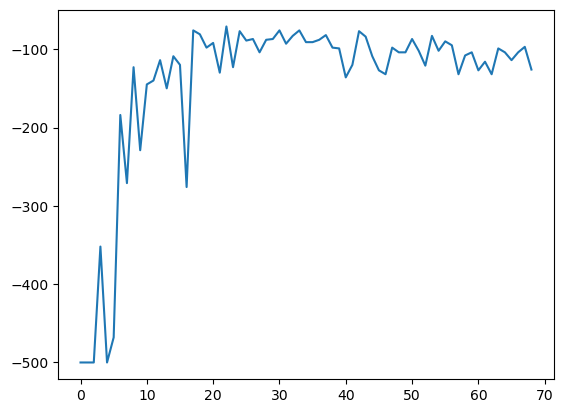

In [14]:
plt.plot(q_returns)
plt.show()

## SARSA (B)

In this section we'll make a slight alteration to the Q learning function above in order to implement SARSA, another classic reinforcement learning algorithm. SARSA is very similar to Q learning except that it uses the _policy_ Q value estimate rather than the _optimal_ Q value estimate. Concretely, this means Q learning uses the update loss

$$
\left \| \hat{Q}(s, a) - \left ( r + \gamma \max_{a'} \hat{Q}(s', a') \right ) \right \|
$$

whereas SARSA first selects an action $a'$ using the same policy we're using for exploration (that is, it uses the $\epsilon$-greedy scheme) then uses the update rule

$$
\left \| \hat{Q}(s, a) - \left ( r + \gamma \hat{Q}(s', a') \right ) \right \|
$$

The difference between the two is only how $a'$ is selected. For SARSA we use the same $\varepsilon$-greedy policy we use to choose actions to take in the environment, for Q learning we use the true greedy action without any random chance. Modify the Q learning function above so that if the `sarsa` argument is set to true, it uses SARSA and otherwise it uses Q learning. Concretely, this means that rather than taking a maximum over actions on the target Q values of `nst_batch`, you should get a batch of actions using the $\varepsilon$-greedy strategy and use those actions to index into the target Q values of `nst_batch`. (This is similar to how you use the actions `act_batch` to index into the policy Q values of `st_batch` in Q learning.)

In [26]:
s_policy, s_returns = train_q_learning(env, lr=2e-4, num_interactions=10000, sarsa=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

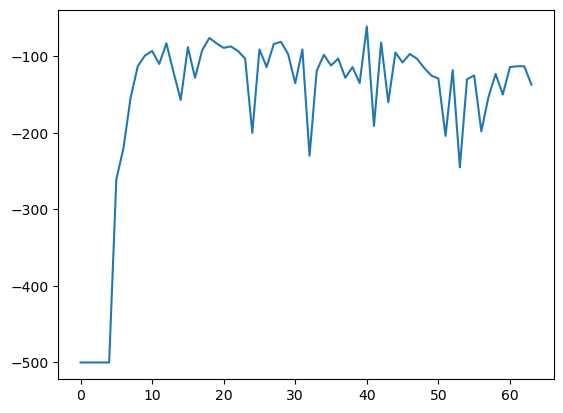

In [27]:
plt.plot(s_returns)
plt.show()

## Actor-Critic (A)

In this section we'll solve the same environment using an actor-critic algorithm rather than Q-learning. For this you'll need to define a policy network and a critic network then fill in the training code below. Actor-critic algorithms come in different flavors, but for this homework we'll optimize the critic $\hat{V}$ to minimize

$$
L(\hat{V}) = \sum_{(s, a, r, s') \in D} \left \| \hat{V}(s) - \left ( r + \gamma \hat{V}(s') \right ) \right \|
$$

and optimize the policy $\pi$ to maximize

$$
J(\pi) = \sum_{(s, a, r, s') \in D} \left ( r + \gamma \hat{V}(s') - \hat{V}(s) \right ) \log \pi(a \mid s)
$$

To make things a bit easier, we'll use a single PyTorch optimizer object trained on the loss $\beta L(\hat{V}) - J(\pi)$ where $\beta$ is a hyperparameter controlling how much relative weight to give the critic loss. You shouldn't need to tune $\beta$ for this homework.

It's also often useful to explicitly encourage exploration by giving the policy a reward based on it's entropy. Mathematically,

$$
J(\pi) = \sum_{(s, a, r, s') \in D} \left ( r + \gamma \hat{V}(s') - \hat{V}(s) \right ) \log \pi(a \mid s) + \alpha H \left ( \pi(\cdot \mid s) \right )
$$

where $H$ measures entropy. This is optional for this homework but may help you get better performance.

In order to make training feasible, you should have your policy network output a PyTorch distribution object (available in `torch.distributions`). Distribution objects have a `.log_prob(a)` method which can tell you the probability of selecting action `a` and an `.entropy()` method which gives you their entropy.

In [ ]:
class Policy(nn.Module):

    def __init__(self, state_dim, num_actions):
        super().__init__()
        # set up self.model. This should be a neural network which outputs
        # logits for each action.
        pass

    def forward(self, x):
        logits = self.model(x)
        return torch.distributions.Categorical(logits=logits)


class Critic(nn.Module):

    def __init__(self, state_dim):
        super().__init__()
        # Set up self.model. This should be a neural network which outputs
        # a single number.
        pass

    def forward(self, x):
        return self.model(x).squeeze(dim=-1)

In [ ]:
def actor_critic(env, critic_weight=0.5, entropy_weight=0.2, lr=1e-3, num_interactions=10000, gamma=0.99, update_interval=10):

    actor = Policy(env.state_dim, env.num_actions)
    critic = Critic(env.state_dim)

    opt = optim.Adam(list(actor.parameters()) + list(critic.parameters()), lr=lr)
    critic_loss_func = nn.SmoothL1Loss()

    replay_buffer = ReplayMemory(update_interval)

    state, _ = env.reset()
    ep_rew = 0
    ep_rewards = []

    for step_count in tqdm(range(num_interactions)):
        
        # Choose an action for the environment. We're no longer using the
        # epsilon-greedy approach since our policy is now stochastic. Instead
        # you should get a distribution by calling your policy network then use
        # the distribution's .sample() method to choose an action.

        if (step_count + 1) % update_interval == 0:
            batch = replay_buffer.sample(update_interval)
            st_batch, act_batch, r_batch, nst_batch, t_batch = zip(*batch)
            st_batch = torch.tensor(np.array(st_batch)).float()
            act_batch = torch.tensor(np.array(act_batch))
            r_batch = torch.tensor(np.array(r_batch)).float()
            nst_batch = torch.tensor(np.array(nst_batch)).float()
            t_batch = torch.tensor(np.array(t_batch))
            replay_buffer.empty()

            # Compute the total loss L(V) - J(\pi).
            
            # You can use actor(st_batch) to get the policy action distribution
            # for each state then call .log_prob(act_batch) on those values to
            # get log \pi(a | s).

            # If you want to add entropy weighting, you can call .entropy() on
            # the distribution.

            # Take a gradient step. Since we put everything together into one
            # optimizer, this is just like the gradient steps we've seen before

        if term or trunc:
            state, _ = env.reset()
            ep_rewards.append(ep_rew)
            ep_rew = 0

    return actor, ep_rewards

In [ ]:
env = AcrobotEnv()
ac_policy, ac_returns = actor_critic(env, num_interactions=100000, entropy_weight=0.2)

In [ ]:
plt.plot(ac_returns)
plt.show()